In [1]:
import matplotlib; print(matplotlib.__version__)

3.3.4


In [6]:
%conda install cartopy shapely

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\story\Anaconda3\envs\mpl3.3

  added / updated specs:
    - cartopy
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cartopy-0.18.0             |   py39h80a4efb_1         1.8 MB
    scipy-1.6.2                |   py39h14eb087_0        16.6 MB
    shapely-1.7.0              |   py39h06580b3_0         402 KB
    ------------------------------------------------------------
                                           Total:        18.8 MB

The following NEW packages will be INSTALLED:

  cartopy            pkgs/main/win-64::cartopy-0.18.0-py39h80a4efb_1
  geos               pkgs/main/win-64::geos-3.8.0-h33f27b4_0
  icc_rt             pkgs/main/win-64::icc_rt-2019.0.0-h0cc432a_1
  proj               pkgs/main/win-64::proj-6.2.1-h9f7ef89_0
  pyshp              pkgs/main/noarch::pyshp-2.1

In [3]:
from pathlib import Path

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.table as mtable
import matplotlib.cm as mcm

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import rcParams

import numpy as np
import pandas as pd


import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import geopandas as gpd


paper_path = Path('../../paper/figures/')

slide_path = Path('../../slides/figures/intro/')
proposal_path = Path('../../draft/figures/intro/')
#rcParams['font.family'] = 'Segoe Print'

ModuleNotFoundError: No module named 'pandas'

In [4]:
ny = pd.read_csv("nydata")

In [5]:
ny['TAVG'] = (ny['DATA_VALUE'].astype(float)/10) *(9/5) + 32

In [6]:
ny['DATES'] = pd.to_datetime(ny['DATE'])

In [7]:
nymap = ny.groupby('NAME').agg({'TAVG':'mean', 'LATITUDE':'mean', 'LONGITUDE':'mean'})

In [8]:
nygdf = gpd.GeoDataFrame(nymap['TAVG'],  geometry=gpd.points_from_xy(nymap['LONGITUDE'], nymap['LATITUDE']))

In [9]:
ny['TEMP'] = ny['TAVG'].apply(lambda x: f"{x:2.2f}")

In [10]:
dfs = ny[['DATE', 'LATITUDE', 'LONGITUDE', 'TEMP', 'NAME']].sort_values(by='DATE').head(10)

In [11]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', 
                                         category='cultural', name=shapename)
nystate = gpd.read_file(states_shp)

In [12]:
ny['TAVG'].describe()

count    1218.000000
mean       30.779310
std        10.682003
min        -1.480000
25%        23.360000
50%        30.380000
75%        36.500000
max        63.680000
Name: TAVG, dtype: float64

In [13]:
cmap = mcm.RdBu_r
norm = mcolors.Normalize(vmin=25, vmax=35)

In [14]:
def plot_table(ax, dfs, ccolors, edgecolor='k', textcolor='k'):
    tab = mtable.table(ax, cellText=dfs.astype('str').values, cellLoc='center',
                   colLabels=dfs.columns, loc='center')
    #bbox=(0, 0, 1, 1))
    tab.auto_set_font_size(False)
    tab.set_fontsize('medium')
    tab.scale(1.25, 1.5)
    tab.auto_set_column_width(np.arange(len(dfs.columns)))
    for i, color in enumerate(ccolors):
        for j in range(len(dfs)+1):
            if textcolor is None:
                tab[(j,i)].get_text().set_color(color)
            else:
                tab[(j,i)].get_text().set_color(textcolor)
                
            tab[(j,i)].set_edgecolor(edgecolor)    
    
    ax.set(xticks=[], yticks=[], aspect='equal')
    ax.axis('off')
    ax.add_table(tab)
    return tab

In [15]:
colors = ['#e6194B','#42d4f4','#9A6324', '#4363d8','#469990', '#3cb44b', 
          '#ffe119', '#f58231', '#f032e6', '#fabed4', '#dcbeff', 
          '#800000', '#aaffc3', '#000075']
cdict = dict(zip(ny['NAME'].unique(), colors))
cdict

{'GANG MILLS NEW YORK': '#e6194B',
 'SARA NEW YORK': '#42d4f4',
 'SCHROON LAKE NEW YORK': '#9A6324',
 'SHERBURNE NEW YORK': '#4363d8',
 'STONYKILL NEW YORK': '#469990',
 'BINGHAMTON': '#3cb44b',
 'ISLIP LI MACARTHUR AP': '#ffe119',
 'NEW YORK LAGUARDIA AP': '#f58231',
 'BUFFALO': '#f032e6',
 'ALBANY AP': '#fabed4',
 'GLENS FALLS AP': '#dcbeff',
 'ROCHESTER GTR INTL AP': '#800000',
 'SYRACUSE HANCOCK INTL AP': '#aaffc3',
 'NEW YORK JFK INTL AP': '#000075'}

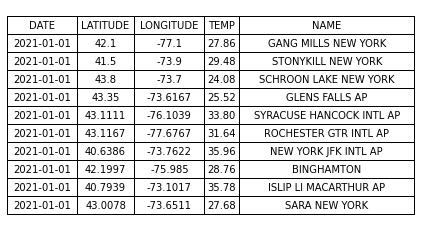

In [16]:
fig, ax = plt.subplots()
tab = plot_table(ax, dfs, ['black', 'black', 'black', 'black', 'black'])
fig.savefig(slide_path/"table.png", bbox_inches='tight')

In [ ]:
fade='dimgray'
fig, axd = plt.subplot_mosaic([['table', 'map',],
                               ['table', 'time',]], 
                              constrained_layout=True, figsize=(12,4))
tab = plot_table(axd['table'], dfs, ['black', 'black', 'black', 'black', 'black'],  edgecolor=fade, textcolor=fade)
tab[(0,4)].get_text().set_text('STATION')

for name, df in ny.groupby(['NAME']):
    axd['time'].plot('DATES', 'TAVG', data=df, label=name,  alpha=.75, color=cdict[name])

    gdf = nygdf.loc[[name], ['TAVG','geometry']]
    gdf.plot(ax=axd['map'], facecolor=cmap(norm(gdf['TAVG'])), edgecolor=cdict[name], 
            linewidth=2.5, alpha=.75, markersize=100)
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

nystate[nystate['postal'].str.match('NY')].plot(ax=axd['map'], facecolor='white', edgecolor=fade, zorder=-1)
ax1_divider = make_axes_locatable(axd['map'])
cax = ax1_divider.append_axes("right", size="5%", pad="2%")
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap,norm=norm, orientation='vertical', drawedges=False)
axd['map'].set_aspect('equal')
axd['map'].axis('off')

for ax in [axd['map'],axd['time'], cax]:
    ax.tick_params(color=fade, labelcolor=fade)
    ax.spines[:].set_color(fade)

#arrows
arrow_kws = {'linewidth':3, 'mutation_scale':25} 
font_kw = {'fontsize':14, 'fontweight':'bold', 'va':'center', 'ha':'left', 'zorder':15}
bbox = {'facecolor':'white', 'edgecolor':'white','pad':.02}
pos_color = 'dimgray'
#x position
xpos_map = mpatches.ConnectionPatch(xyA=(.35,.77), coordsA=axd['table'].transData,
                                     xyB=(-73.9, 42.2), coordsB=axd['map'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=90", 
                        connectionstyle="arc,angleA=90, angleB=90,armA=5, armB=20,rad=5", 
                                    color=pos_color, zorder=10, **arrow_kws)
fig.add_artist(xpos_map)
fig.text(.52, .8, "x position", bbox=bbox, color=pos_color, **font_kw)
tab[(2,2)].get_text().set_color(pos_color)

#y position
ypos_map = mpatches.ConnectionPatch(xyA=(.09,.72), coordsA=axd['table'].transData,
                                     xyB=(-74.5, 41.5), coordsB=axd['map'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=180", 
                                    connectionstyle='arc,angleA=270, angleB=180,armA=5, armB=30,rad=5', 
                                    color=pos_color,zorder=10, **arrow_kws)#"angle,angleA=90,angleB=180"
fig.add_artist(ypos_map)
fig.text(.65,.67, "y position", color=pos_color, bbox=bbox, **font_kw)
tab[(2,1)].get_text().set_color(pos_color)

#edgecolor
edge_color = cdict['STONYKILL NEW YORK']
edge_map = mpatches.ConnectionPatch(xyA=(1.18,.75), coordsA=axd['table'].transData,
                                    xyB=(-73.9, 41.25), coordsB=axd['map'].transData,   
                                    arrowstyle="->", connectionstyle="angle3, angleA=-15, angleB=-145", 
                                    color=edge_color,**arrow_kws)
fig.add_artist(edge_map)
fig.text(.675,.61, "edgecolor", color=edge_color, bbox=bbox, **font_kw)
tab[(2,4)].get_text().set_color(edge_color)

#facecolor
face_color = cmap(norm(nygdf['TAVG']['STONYKILL NEW YORK']))
face_map = mpatches.ConnectionPatch(xyA=(.6,.75), coordsA=axd['table'].transData,
                                    xyB=(-73.95, 41.4), coordsB=axd['map'].transData,   
                                    arrowstyle="->", connectionstyle="angle3, angleA=15,angleB=-140", 
                                    color=face_color,**arrow_kws)
fig.add_artist(face_map)
fig.text(.55, 1.0, "facecolor", color=face_color, bbox=bbox, rotation=10, **font_kw)
tab[(2,3)].get_text().set_color(face_color)


# time
#x position
xpos_map = mpatches.ConnectionPatch(xyA=(-0.17,.31), coordsA=axd['table'].transData,
                                     xyB=(18628, 20), coordsB=axd['time'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=90", 
                        connectionstyle="arc,angleA=-90, angleB=-90,armA=20, armB=20,rad=5", 
                                    color=pos_color, zorder=10, **arrow_kws)
fig.add_artist(xpos_map)
fig.text(.39, .21, "x position", bbox=bbox, color=pos_color, rotation=-5, **font_kw)
tab[(7,2)].get_text().set_color(pos_color)

#y position
ypos_map = mpatches.ConnectionPatch(xyA=(.55,.32), coordsA=axd['table'].transData,
                                     xyB=(18626, 35.96), coordsB=axd['time'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=180", 
                                    connectionstyle='arc,angleA=270, angleB=180,armA=10, armB=30,rad=5', 
                                    color=pos_color,zorder=10, **arrow_kws)#"angle,angleA=90,angleB=180"
fig.add_artist(ypos_map)
fig.text(.39,.36, "y position", color=pos_color, bbox=bbox, **font_kw)
tab[(7,3)].get_text().set_color(pos_color)

# color
line_color = cdict['NEW YORK JFK INTL AP']
face_map = mpatches.ConnectionPatch(xyA=(1.19,.35), coordsA=axd['table'].transData,
                                    xyB=(18629, 39), coordsB=axd['time'].transData,   
                                    arrowstyle="->", connectionstyle="angle3, angleA=15,angleB=-140", 
                                    color=line_color,**arrow_kws)
fig.add_artist(face_map)
fig.text(.47, .45, "color", color=line_color, rotation=5, bbox=bbox, **font_kw)
tab[(7,4)].get_text().set_color(line_color)

#artist
#artist
#fig.text(.145, .7, "point", fontsize=40, color=acolor, zorder=20,
#          bbox={'boxstyle':'rarrow', 'edgecolor':acolor, 
#                'linewidth':5, 'facecolor':'none', 'pad':1, 'mutation_aspect':.5})
acolor= '#A50B5E'
afont_kws = {'fontsize':24, 'fontweight':'bold', 'va':'center', 'ha':'left', 'zorder':25}
artist_kws = {'linewidth':5, 'edgecolor':acolor, 'facecolor':'none', 'alpha':.2, 'zorder':20, 
              'arrowstyle':'fancy', 'mutation_scale':550 }
point_artist = mpatches.ConnectionPatch(xyA=(-.2,.75), coordsA=axd['table'].transData,
                                        xyB=(-70, 42.5), coordsB=axd['map'].transData, **artist_kws)
#fig.add_artist(point_artist)
#fig.text(.155,1.075, "point", rotation=-12, color=acolor, **afont_kws)



acolor ='#6c3483'
artist_kws = {'linewidth':5, 'edgecolor':acolor, 'facecolor':'none', 'alpha':.2, 'zorder':20, 
              'arrowstyle':'fancy', 'mutation_scale':550 }

point_artist = mpatches.ConnectionPatch(xyA=(-.5,.32), coordsA=axd['table'].transData,
                                        xyB=(18645, 37), coordsB=axd['time'].transData, **artist_kws)
#fig.add_artist(point_artist)
#fig.text(.03,.095, "line", rotation=12, color=acolor, **afont_kws)
fig.savefig(proposal_path/"functions.png")

In [ ]:
nyjfk = ny[ny['NAME'].str.contains("JFK")]

In [ ]:
nyjfk['TAVG2'] = nyjfk['TAVG']*2

In [ ]:
nyjfk['TEMP2'] = nyjfk['TAVG2'].apply(lambda x: f"{x:2.2f}")

In [ ]:
dfs = nyjfk.head(10)

In [ ]:
fig, axd = plt.subplot_mosaic([['tab1','tab2', 'time']], gridspec_kw={'width_ratios':[1,1,2]},
                              constrained_layout=True, figsize=(9,3))

tab = plot_table(axd['tab1'], dfs[['DATE', 'TEMP']], ['k', 'tab:blue'], textcolor=None)
tab2 = plot_table(axd['tab2'], dfs[['DATE', 'TEMP2']], ['k','tab:orange'], textcolor=None)
tab2[(0,1)].get_text().set_text('TEMPERATURE')
tab[(0,1)].get_text().set_text('TEMPERATURE')
axd['time'].plot('DATES', 'TAVG', data=nyjfk, color='tab:blue')
axd['time'].plot('DATES', 'TAVG2', data=nyjfk, color='tab:orange')
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
axd['time'].set_ylabel("temperature (°F)")

a_color = 'tab:green'

for y in np.array([.075, .25, .42, .58, .75, .91])-.04:
    con_ft = mpatches.ConnectionPatch(xyA=(.88,y), coordsA=axd['tab1'].transData,
                            xyB=(.67, y), coordsB=axd['tab2'].transData,   
                             arrowstyle="fancy", mutation_scale=60, 
                            facecolor=a_color, edgecolor='black', alpha=.5)
    fig.add_artist(con_ft)
    
for (i, (d, t1, t2)) in nyjfk[['DATES', 'TAVG', 'TAVG2']].iloc[::2].iterrows():
    a1 = mpatches.FancyArrowPatch((d, t1), (d,t2), arrowstyle="->",  
                                  linestyle=None, mutation_scale=15, color=a_color)
    axd['time'].add_artist(a1)
fig.savefig(proposal_path/"equivariant.png")

In [ ]:
table = np.array([["sun", 1], ["clouds", 4], ['rain', 2], ['lightning', 3], ['storm', 2]])

In [ ]:
fig, axd = plt.subplot_mosaic([['tab','plot'], ['tab', 'bar']], gridspec_kw={'width_ratios':[1,1]}, 
                              constrained_layout=True, figsize=(6,2))

tab = axd['tab'].table(cellText=table.astype('str'), bbox=(0, 0, 1, 1))
tab.set_fontsize('xx-large')
axd['tab'].set(xticks=[], yticks=[], aspect='equal')
axd['plot'].plot(table[:,0], table[:,1].astype(int), color='tab:green')
axd['bar'].bar(table[:,0], table[:,1].astype(int), color='tab:green')
for n in ['bar', 'plot']:
    #axd[n].set_ylim(0,4.1)
    axd[n].set_ylabel("frequency")
    axd[n].xaxis.set_tick_params(rotation=0)
    axd[n].set_yticks([0, 2.5, 5])
    axd[n].set_yticklabels(['0', '2.5', '5'])
axd['bar'].set_ylim(0,5)
axd['plot'].set_ylim(0, 5)

fig.savefig(paper_path/"continuity.png")

In [ ]:
nybar = nygdf.reset_index()
nybar['TEMP'] = nybar['TAVG'].apply(lambda x: f"{x:2.2f}")

In [ ]:
nybar['SHORT'] = nybar['NAME'].str.replace("NEW YORK|AP|INTL|ISLIP LI|GTR|SYRACUSE", "", regex=True)

In [ ]:
nybar['NAME']

In [ ]:
fig, axd = plt.subplot_mosaic([['tab','plot'], ['tab', 'bar']], gridspec_kw={'width_ratios':[1,1]}, 
                              constrained_layout=True, figsize=(12,4))
tab = plot_table(axd['tab'], nybar[['NAME', 'TEMP']], ['k', 'tab:green'], textcolor=None)
tab[(0,1)].get_text().set_text("Temperature")
tab[(0,0)].get_text().set_text("Station")
tab[(0,1)].get_text().set_color("k")
for i in range(len(cdict)):
    station = tab[(i+1,0)].get_text().get_text()
    tab[(i+1,0)].set_facecolor(cdict[station])
    tab[(i+1,0)].set_alpha(.25)
    tab[(i+1,0)].get_text().set_color("black")
axd['bar'].bar(nybar['SHORT'], nybar['TAVG'], color=[cdict[n] for n in nybar['NAME']])
axd['bar'].tick_params("x", rotation=90)
axd['plot'].tick_params("x", rotation=90)
axd['plot'].plot(nybar['SHORT'], nybar['TAVG'], color='tab:green')
axd['plot'].sharex(axd['bar'])
axd['plot'].sharey(axd['bar'])
axd['bar'].set_yticks([0,10,20,30])
axd['bar'].set_xlim(-0.75,13.75)
axd['bar'].set_ylabel("Average Temp (°F)")
axd['plot'].set_ylabel("Average Temp (°F)")
fig.subplots_adjust(hspace=0.)

fig.savefig(proposal_path/"continuity.png")

In [ ]:
df['']

In [ ]:
tab[(0,0)].get_text?

In [ ]:
tab[(0,0)].get_text().get_text()

In [ ]:
fig, axd = plt.subplot_mosaic([['tab','plot'], ['tab', 'bar']], gridspec_kw={'width_ratios':[1,1]}, 
                              constrained_layout=True, figsize=(6,2))
